In [1]:
import pandas as pd
import datetime as dt
import sys
sys.path.append('../lib/')
from datetime import timedelta
from utils import *
from preprocessing_analysis import *
from forecasting_analysis import psf_forecasting, plot_model_forecasting, \
                                 accuracy_metric

In [2]:
filepath_data = '../Data/'
filename = 'Poland_Load_H_resampled.csv'
df = pd.read_csv(
    filepath_data + filename, index_col=['Date'],parse_dates=['Date']
    )

df

,Hour,Minutes,Load,Load_denoised,Day,Holiday,Day id,Load_detrend,Load_lin_seasonal,Load_real_comp
Date,,,,,,,,,,
2008-01-01 00:00:00,0.0,30.0,47475.5,47346.803660,1,True,1,-21433.170550,76229.951636,-28883.147976
2008-01-01 01:00:00,1.0,22.5,60819.9,60916.440498,1,True,1,-7863.613023,76230.351592,-15313.911094
2008-01-01 02:00:00,2.0,22.5,57869.8,57844.668724,1,True,1,-10935.464108,76230.748508,-18386.079784
2008-01-01 03:00:00,3.0,22.5,55672.8,55751.026446,1,True,1,-13029.185696,76231.142384,-20480.115938
2008-01-01 04:00:00,4.0,22.5,55331.7,55269.909471,1,True,1,-13510.381982,76231.533220,-20961.623749
...,...,...,...,...,...,...,...,...,...,...
2016-12-31 19:00:00,19.0,22.5,74952.5,74961.384819,5,False,366,-76.752067,82486.465497,-7525.080678
2016-12-31 20:00:00,20.0,22.5,70390.3,70477.880585,5,False,366,-4560.335612,82486.880648,-12009.000063
2016-12-31 21:00:00,21.0,22.5,66925.1,66827.278809,5,False,366,-8211.016698,82487.292761,-15660.013952


In [3]:
cut_dates = [dt.datetime(2016, 12, 25, 0)] \
                 + [df.index[-1] - timedelta(days=i*30-1) for i in range(1, 12)] \
                 + [dt.datetime(2016, 1, 2, 23)]

[1 + (df.index[-1] - date).days for date in cut_dates]

[7, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 365]

In [53]:
dfs = []
for cut_date in cut_dates:
    print(cut_date)
    tmp = psf_forecasting(df, cut_day=cut_date)
    dfs.append(tmp)

2016-12-25 00:00:00
2016-12-02 23:00:00
2016-11-02 23:00:00
2016-10-03 23:00:00
2016-09-03 23:00:00
2016-08-04 23:00:00
2016-07-05 23:00:00
2016-06-05 23:00:00
2016-05-06 23:00:00
2016-04-06 23:00:00
2016-03-07 23:00:00
2016-02-06 23:00:00
2016-01-02 23:00:00


In [54]:
model = 'PSF'
results_path = f'../Results/{model}/'

for df1 in dfs:
    freq = df1.index.inferred_freq
    mask = df1.forecast.notna()
    n_days = 1 + (df1.loc[mask].index[-1] - df1.loc[mask].index[0]).days
    file = f"PSF_{freq}_{n_days}days.csv"
    df1[df1.forecast.notna()].to_csv(results_path + file, index=True)

In [61]:
dfs[0]

,Load,Load_denoised,forecast,q1_forecast,q2_forecast
Date,,,,,
2008-01-01 00:00:00,47475.5,NaN,NaN,NaN,NaN
2008-01-01 01:00:00,60819.9,NaN,NaN,NaN,NaN
2008-01-01 02:00:00,57869.8,NaN,NaN,NaN,NaN
2008-01-01 03:00:00,55672.8,NaN,NaN,NaN,NaN
2008-01-01 04:00:00,55331.7,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2016-12-31 19:00:00,74952.5,74961.384819,84462.917000,76835.805603,91721.687336
2016-12-31 20:00:00,70390.3,70477.880585,84155.289785,78918.271176,89305.928673
2016-12-31 21:00:00,66925.1,66827.278809,81750.562189,77079.531927,85926.660158


In [65]:
plt.close()

'PSF'

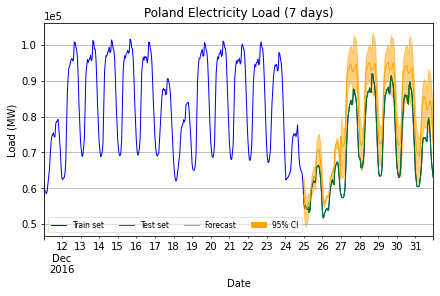

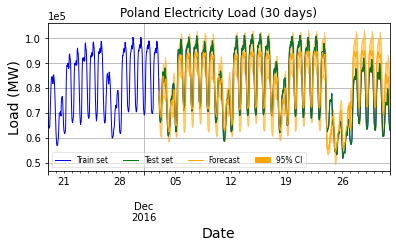

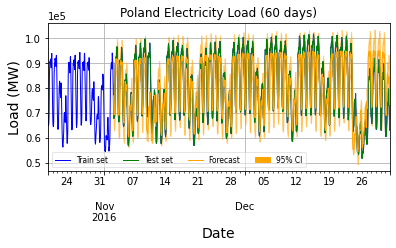

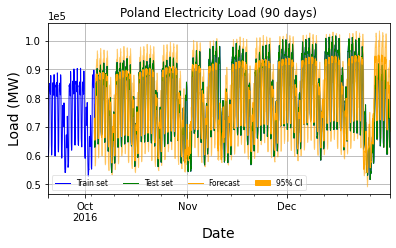

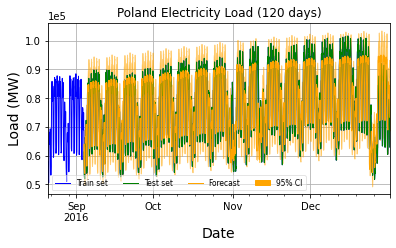

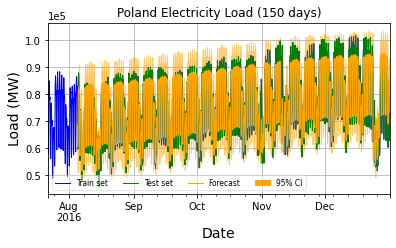

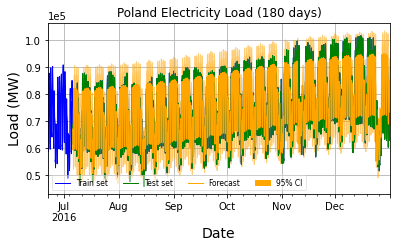

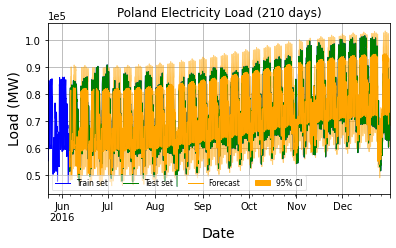

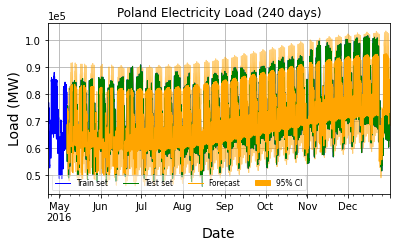

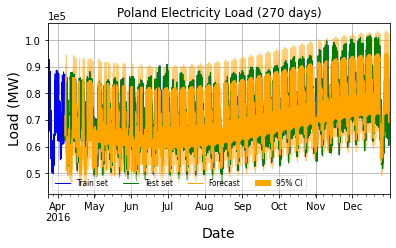

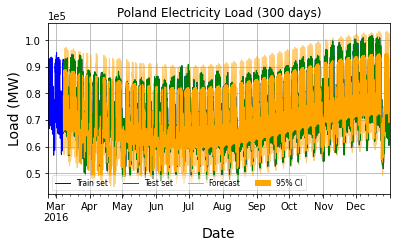

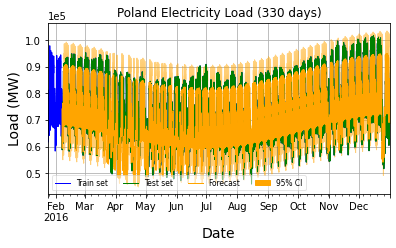

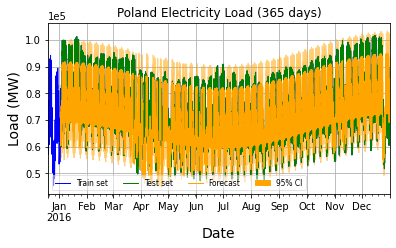

In [4]:
cut_dates = [dt.datetime(2016, 12, 25, 0)] \
            + [df.index[-1] - timedelta(days=i*30-1) for i in range(1, 12)] \
            + [dt.datetime(2016, 1, 2, 23)]

freq = 'H'
model = 'PSF'
results_path = f'../Results/{model}/'

files = get_result_filenames(results_path, freq=freq)

dfs = []
for file, cut_date in zip(files, cut_dates):
    res = pd.read_csv(
        results_path + file, index_col=['Date'], parse_dates=['Date']
        )
    tmp = df[['Load']].copy()
    tmp.loc[res.index, res.columns] = res    
    
    plot_model_forecasting(df=tmp, cut_day=cut_date, model=model)
    
    dfs.append(tmp)

In [5]:
table = accuracy_metric(dfs, cut_dates)
table

,cut date,accuracy,mape,rel err
0,2016-12-25 00:00:00,35.12,10.07,12.65
1,2016-12-02 23:00:00,78.77,5.21,14.01
2,2016-11-02 23:00:00,84.47,4.61,14.17
3,2016-10-03 23:00:00,87.27,4.12,14.36
4,2016-09-03 23:00:00,89.92,3.85,14.85
5,2016-08-04 23:00:00,91.0,3.64,15.17
6,2016-07-05 23:00:00,92.23,3.48,15.56
7,2016-06-05 23:00:00,89.52,3.81,15.41
8,2016-05-06 23:00:00,86.68,4.29,15.07
9,2016-04-06 23:00:00,83.85,4.87,14.54


In [60]:
filename = 'PSF_accuracy.tex'
filepath = '../Results/Latex_tables/'

        
latex_table_generator(table, filepath+filename)

In [17]:
plt.close()

In [18]:
def plot_model_forecasting_trial(df, cut_day, model, feature = 'Load',
                           file=None, ax = None, legend = None, xlabel=None):
   
    freq = df.index.inferred_freq 
    if freq == 'W-SUN':
        weeks = 52
        n_weeks = ((df.index[-1] - cut_day).days + 1) // 7
        time_interval = n_weeks
        interval_type = 'weeks'     
    else:
        weeks = 2
        n_days = (df.index[-1] - cut_day).days + 1
        time_interval = n_days
        interval_type = 'days'
        
    date = cut_day - dt.timedelta(weeks=weeks)
    cut_mask = df.index >= cut_day
    date_mask = df.index > date
    
    if not ax:
        ax = latex_settings()
        legend = True
        xlabel = 'Date'
        file = f'{model}_{freq}_{time_interval}{interval_type}.png'
    
    df.loc[date_mask, [feature]].plot(ax=ax, color='b', lw=1, legend=legend)
    df.loc[cut_mask, [feature, 'forecast']].plot(ax=ax,
                                                 color=['g', 'orange'],
                                                 lw=1, legend=legend)
    ax.fill_between(x=df[date_mask].index,
                    y1=df[date_mask].q1_forecast,
                    y2=df[date_mask].q2_forecast,
                    color='orange', alpha=0.5, lw=1)
    ax.grid()
    ax.set_ylabel('Load (MW)')
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    ax.set_xlabel(xlabel)
    ax.set_title(f'Poland Electricity Load ({time_interval} {interval_type})')
    
    if legend:
        leg = plt.legend(loc="lower left", ncol=4, fancybox=True,
                         framealpha=0.5, fontsize=7.5,
                         labels=['Train set', 'Test set', 'Forecast', '95% CI'])
        fancy_legend(leg)

In [19]:
panels = ['(a)', '(b)', '(c)']
axs = latex_settings(len(dfs[:3]), 1, 2.5)
legends = [False, False, True]
xlabels = [None, None, 'Date']

for i, tmp in enumerate(dfs[:3]):
    plot_model_forecasting_trial(
        df=tmp, cut_day=cut_dates[i], model=model,
        ax=axs[i], legend=legends[i], xlabel=xlabels[i]
        )
    # label physical distance in and down:
    axs[i].annotate(xy=(0.01, 0.97), text=panels[i], xycoords='axes fraction', 
            fontsize='medium', verticalalignment='top', weight='bold',
            bbox=dict(facecolor='none', edgecolor='none', pad=3.0))

model = 'PSF' 
filepath_img = f'../Images/{model}/' 
plt.savefig(filepath_img + 'PSF_H_days.png', dpi=800, trasparent=True)
plt.show()
plt.close()

<ipython-input-19-187cf7d13fc0>:18: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "trasparent" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(filepath_img + 'PSF_H_days.png', dpi=800, trasparent=True)
